In [23]:
# Import Necessary Libraries for EDA and Preprocessing
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from collections import Counter
from nltk.corpus import stopwords

In [21]:
#Read data
def get_labels_and_texts(file_path, num_samples=None):
    labels = []
    texts = []

    with open(file_path, "r", encoding='utf-8') as f:
        for i, line in enumerate(f):
            if num_samples is not None and i >= num_samples:
                break
            x = line.split(" ", 1)  
            labels.append(int(x[0].split("__label__")[1]) - 1) 
            texts.append(x[1].strip())
    
    print(f"Loaded {len(labels)} samples from {file_path}.")  
    return np.array(labels), texts

def load_data():
    train_file = os.path.join("..", "Dataset", "train.ft.txt")  
    test_file = os.path.join("..", "Dataset", "test.ft.txt")    

    train_labels, train_texts = get_labels_and_texts(train_file, num_samples=3600000)
    test_labels, test_texts = get_labels_and_texts(test_file, num_samples=400000)

    train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
    test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

    print(f"Training data shape: {train_df.shape}")  
    print(f"Testing data shape: {test_df.shape}")    
    
    return train_df, test_df

train_df, test_df = load_data()
train_df.head()

Loaded 3600000 samples from ..\Dataset\train.ft.txt.
Loaded 400000 samples from ..\Dataset\test.ft.txt.
Training data shape: (3600000, 2)
Testing data shape: (400000, 2)


,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [4]:
# Check for missing values in Train and Test DataFrames
print("Checking for missing values in the dataset...\n")
print("Missing values in Train DataFrame:")
print(train_df.isnull().sum())
print("\nMissing values in Test DataFrame:")
print(test_df.isnull().sum())


Checking for missing values in the dataset...

Missing values in Train DataFrame:
text     0
label    0
dtype: int64

Missing values in Test DataFrame:
text     0
label    0
dtype: int64


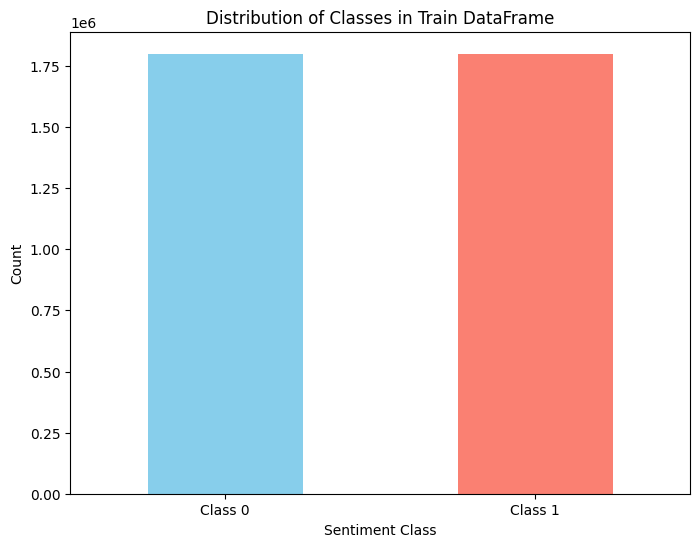

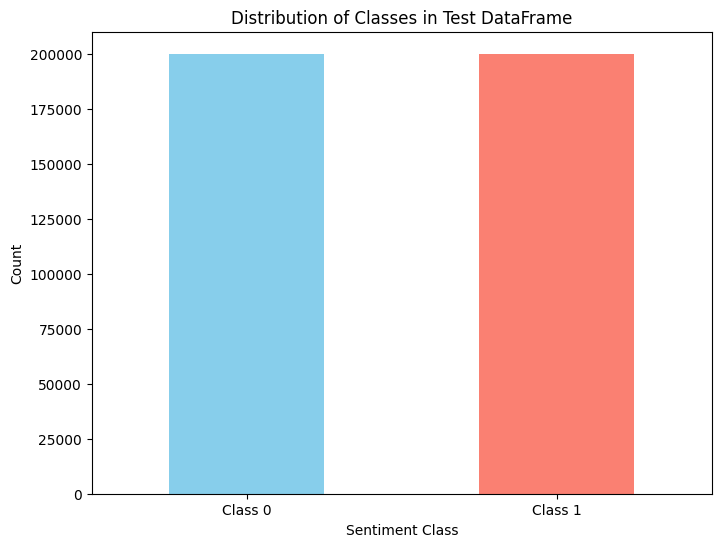

In [24]:
# Visualize the distribution of classes in Train and Test DataFrames
def plot_class_distribution(df, title):
    plt.figure(figsize=(8, 6))
    df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(title)
    plt.xlabel('Sentiment Class')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'], rotation=0) 
    plt.show()
    
plot_class_distribution(train_df, 'Distribution of Classes in Train DataFrame')
plot_class_distribution(test_df, 'Distribution of Classes in Test DataFrame')


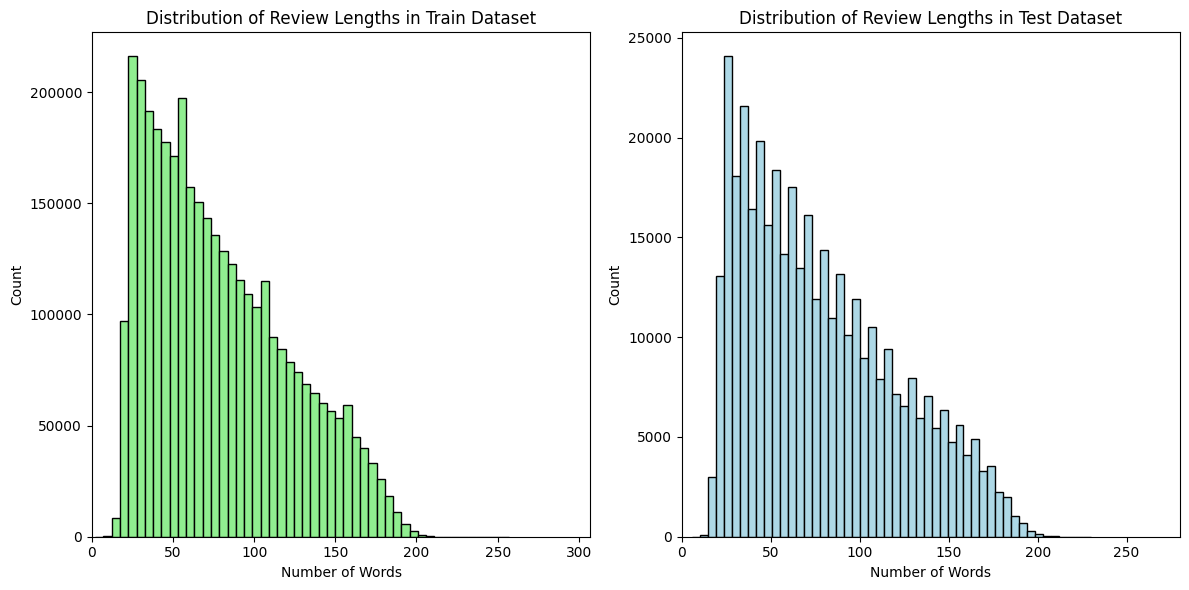

In [26]:
# Calculate the length of each review in terms of the number of words
review_lengths_train = train_df['text'].apply(lambda x: len(re.split(r'\s+', x.strip())))
review_lengths_test = test_df['text'].apply(lambda x: len(re.split(r'\s+', x.strip())))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(review_lengths_train, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Review Lengths in Train Dataset')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.xlim(0, max(review_lengths_train) + 50) 

plt.subplot(1, 2, 2)
plt.hist(review_lengths_test, bins=50, color='lightblue', edgecolor='black')
plt.title('Distribution of Review Lengths in Test Dataset')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.xlim(0, max(review_lengths_test) + 50)  

plt.tight_layout()  
plt.show()


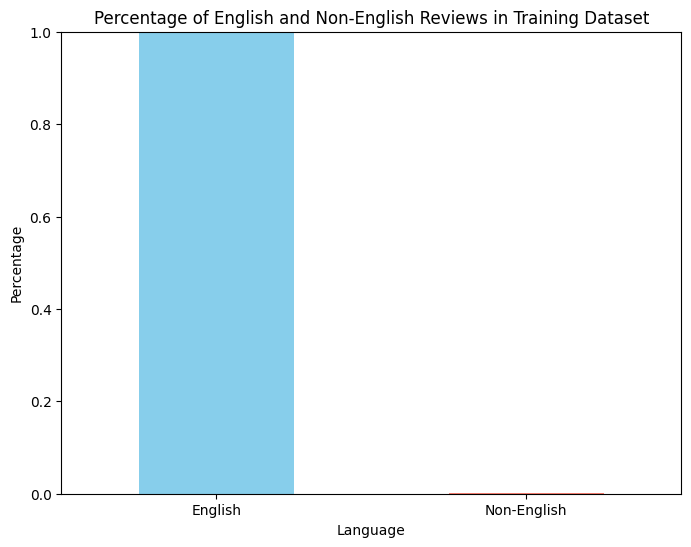


Counts of reviews by language (Training Data):
is_english
English        99.75275
Non-English     0.24725
Name: proportion, dtype: float64


In [28]:
#visualize language detection
def get_labels_and_texts(file, num_samples=None):
    labels = []
    texts = []
    with open(file, "r", encoding='utf-8') as f:
        for i, line in enumerate(f):
            if num_samples is not None and i >= num_samples:
                break
            x = line.split(" ", 1)  
            labels.append(int(x[0].split("__label__")[1]) - 1)
            texts.append(x[1].strip())
    return np.array(labels), texts

train_labels, train_texts = get_labels_and_texts("Dataset/train.ft.txt", num_samples=3600000)
test_labels, test_texts = get_labels_and_texts("Dataset/test.ft.txt", num_samples=400000)

train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

def is_english(review):
    try:
        return detect(review) == 'en'
    except:
        return False  

train_df['is_english'] = train_df['text'].apply(is_english)

language_counts = train_df['is_english'].value_counts(normalize=True).rename(index={True: 'English', False: 'Non-English'})

plt.figure(figsize=(8, 6))
language_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Percentage of English and Non-English Reviews in Training Dataset')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  
plt.ylim(0, 1)  
plt.show()

print("\nCounts of reviews by language (Training Data):")
print(language_counts * 100)  

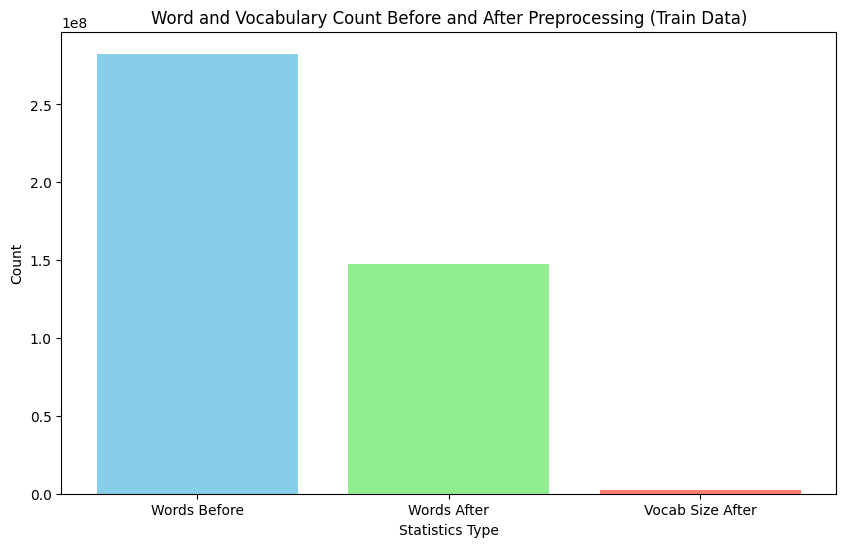

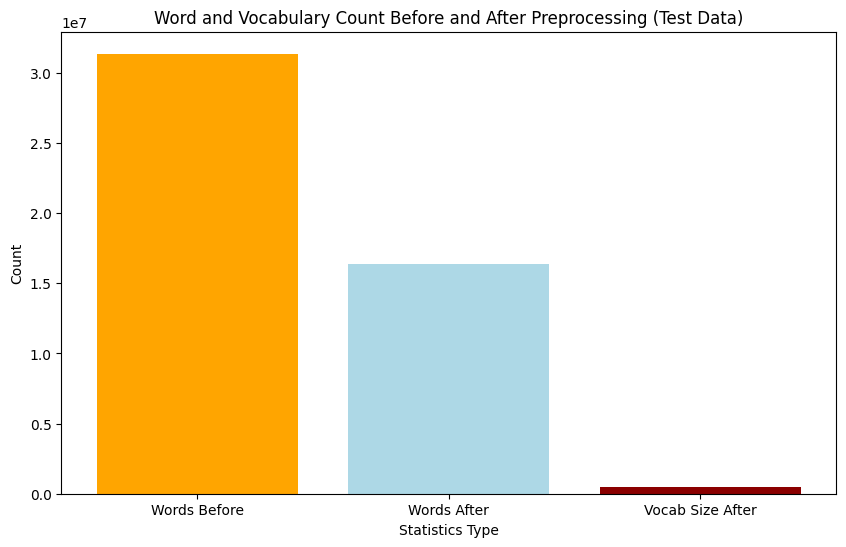

Train Removed Non-Alphanumeric Count: 2799285
Train Removed Stopwords Count: 134890371
Train Removed Non-ASCII Count: 134921677
Test Removed Non-Alphanumeric Count: 311676
Test Removed Stopwords Count: 14967097
Test Removed Non-ASCII Count: 14970733


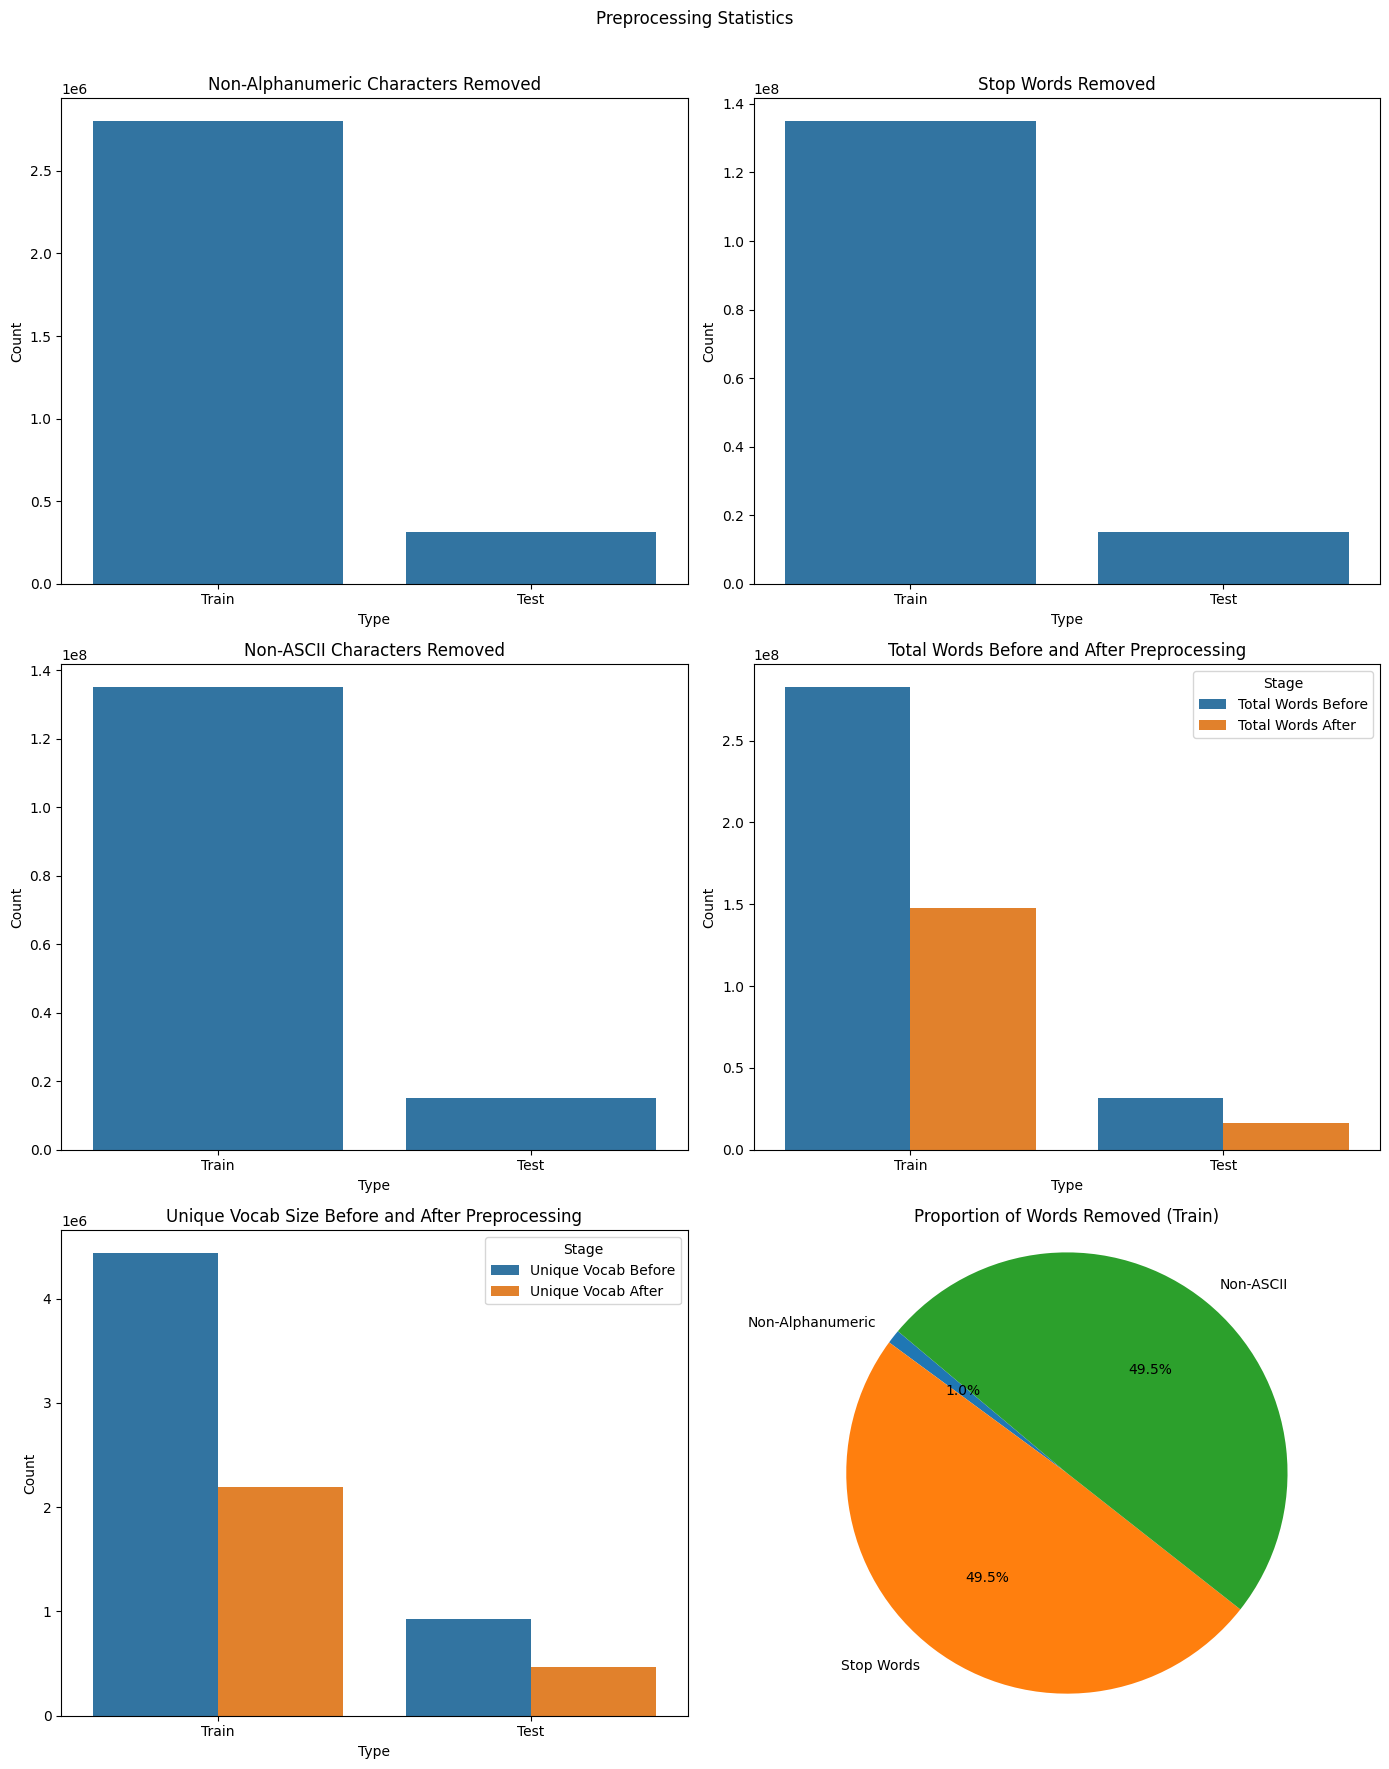

In [14]:
# visualize impacts of cleaning
train_removed_non_alphanum_count = 0
train_removed_stopwords_count = 0
train_removed_nonascii_count = 0
test_removed_non_alphanum_count = 0
test_removed_stopwords_count = 0
test_removed_nonascii_count = 0

train_total_words_before_preprocessing = 0
train_total_words_after_preprocessing = 0
test_total_words_before_preprocessing = 0
test_total_words_after_preprocessing = 0

train_vocab_before_preprocessing = set()
train_vocab_after_preprocessing = set()
test_vocab_before_preprocessing = set()
test_vocab_after_preprocessing = set()

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    labels = []
    texts = []

    for line in lines:
        label, text = line.strip().split(' ', 1)
        labels.append(1 if label == '__label__2' else 0)  
        texts.append(text)

    return texts, labels

def preprocess_text(text, is_train=True):
    global train_removed_non_alphanum_count, train_removed_stopwords_count, train_removed_nonascii_count
    global test_removed_non_alphanum_count, test_removed_stopwords_count, test_removed_nonascii_count
    global train_total_words_before_preprocessing, train_total_words_after_preprocessing
    global test_total_words_before_preprocessing, test_total_words_after_preprocessing
  
    text = text.lower()
    tokens = text.split()
   
    if is_train:
        train_total_words_before_preprocessing += len(tokens)
        train_vocab_before_preprocessing.update(tokens)
    else:
        test_total_words_before_preprocessing += len(tokens)
        test_vocab_before_preprocessing.update(tokens)
   
    tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens]  
    tokens = [re.sub(r'\d+', '<number>', word) for word in tokens] 
    if is_train:
        train_removed_non_alphanum_count += sum(1 for word in tokens if re.search(r'[^\w\s]', word))
    else:
        test_removed_non_alphanum_count += sum(1 for word in tokens if re.search(r'[^\w\s]', word))
 
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    if is_train:
        train_removed_stopwords_count += len(tokens) - len(filtered_tokens)
    else:
        test_removed_stopwords_count += len(tokens) - len(filtered_tokens)
   
    filtered_tokens = [word for word in filtered_tokens if all(ord(char) < 128 for char in word)]
    if is_train:
        train_removed_nonascii_count += len(tokens) - len(filtered_tokens)
    else:
        test_removed_nonascii_count += len(tokens) - len(filtered_tokens)
   
    processed_text = ' '.join(filtered_tokens)
 
    if is_train:
        train_total_words_after_preprocessing += len(filtered_tokens)
        train_vocab_after_preprocessing.update(filtered_tokens)
    else:
        test_total_words_after_preprocessing += len(filtered_tokens)
        test_vocab_after_preprocessing.update(filtered_tokens)

    return processed_text

train_texts, train_labels = load_data("Dataset/train.ft.txt")
test_texts, test_labels = load_data("Dataset/test.ft.txt")

train_texts = [preprocess_text(text, is_train=True) for text in train_texts]
test_texts = [preprocess_text(text, is_train=False) for text in test_texts]

train_statistics = {
    'Type': ['Words Before', 'Words After', 'Vocab Size After'],
    'Count': [train_total_words_before_preprocessing, train_total_words_after_preprocessing, len(train_vocab_after_preprocessing)]
}

test_statistics = {
    'Type': ['Words Before', 'Words After', 'Vocab Size After'],
    'Count': [test_total_words_before_preprocessing, test_total_words_after_preprocessing, len(test_vocab_after_preprocessing)]
}

plt.figure(figsize=(10, 6))
plt.bar(train_statistics['Type'], train_statistics['Count'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Word and Vocabulary Count Before and After Preprocessing (Train Data)')
plt.xlabel('Statistics Type')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(test_statistics['Type'], test_statistics['Count'], color=['orange', 'lightblue', 'darkred'])
plt.title('Word and Vocabulary Count Before and After Preprocessing (Test Data)')
plt.xlabel('Statistics Type')
plt.ylabel('Count')
plt.show()

print(f"Train Removed Non-Alphanumeric Count: {train_removed_non_alphanum_count}")
print(f"Train Removed Stopwords Count: {train_removed_stopwords_count}")
print(f"Train Removed Non-ASCII Count: {train_removed_nonascii_count}")

print(f"Test Removed Non-Alphanumeric Count: {test_removed_non_alphanum_count}")
print(f"Test Removed Stopwords Count: {test_removed_stopwords_count}")
print(f"Test Removed Non-ASCII Count: {test_removed_nonascii_count}")

stats = {
    'Type': ['Train', 'Test'],
    'Non-Alphanumeric Removed': [train_removed_non_alphanum_count, test_removed_non_alphanum_count],
    'Stop Words Removed': [train_removed_stopwords_count, test_removed_stopwords_count],
    'Non-ASCII Removed': [train_removed_nonascii_count, test_removed_nonascii_count],
    'Total Words Before': [train_total_words_before_preprocessing, test_total_words_before_preprocessing],
    'Total Words After': [train_total_words_after_preprocessing, test_total_words_after_preprocessing],
    'Unique Vocab Before': [len(train_vocab_before_preprocessing), len(test_vocab_before_preprocessing)],
    'Unique Vocab After': [len(train_vocab_after_preprocessing), len(test_vocab_after_preprocessing)]
}

df = pd.DataFrame(stats)

fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle('Preprocessing Statistics')

sns.barplot(ax=axes[0, 0], data=df, x='Type', y='Non-Alphanumeric Removed')
axes[0, 0].set_title('Non-Alphanumeric Characters Removed')
axes[0, 0].set_ylabel('Count')

sns.barplot(ax=axes[0, 1], data=df, x='Type', y='Stop Words Removed')
axes[0, 1].set_title('Stop Words Removed')
axes[0, 1].set_ylabel('Count')

sns.barplot(ax=axes[1, 0], data=df, x='Type', y='Non-ASCII Removed')
axes[1, 0].set_title('Non-ASCII Characters Removed')
axes[1, 0].set_ylabel('Count')

df_total_words = df.melt(id_vars=['Type'], value_vars=['Total Words Before', 'Total Words After'], var_name='Stage', value_name='Total Words')
sns.barplot(ax=axes[1, 1], data=df_total_words, x='Type', y='Total Words', hue='Stage')
axes[1, 1].set_title('Total Words Before and After Preprocessing')
axes[1, 1].set_ylabel('Count')

df_vocab_size = df.melt(id_vars=['Type'], value_vars=['Unique Vocab Before', 'Unique Vocab After'], var_name='Stage', value_name='Vocab Size')
sns.barplot(ax=axes[2, 0], data=df_vocab_size, x='Type', y='Vocab Size', hue='Stage')
axes[2, 0].set_title('Unique Vocab Size Before and After Preprocessing')
axes[2, 0].set_ylabel('Count')

def plot_pie_chart(ax, labels, sizes, title):
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')  
    ax.set_title(title)

total_words_removed_train = train_removed_non_alphanum_count + train_removed_stopwords_count + train_removed_nonascii_count
total_words_removed_test = test_removed_non_alphanum_count + test_removed_stopwords_count + test_removed_nonascii_count

plot_pie_chart(axes[2, 1],
               ['Non-Alphanumeric', 'Stop Words', 'Non-ASCII'],
               [train_removed_non_alphanum_count / total_words_removed_train,
                train_removed_stopwords_count / total_words_removed_train,
                train_removed_nonascii_count / total_words_removed_train],
               'Proportion of Words Removed (Train)')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


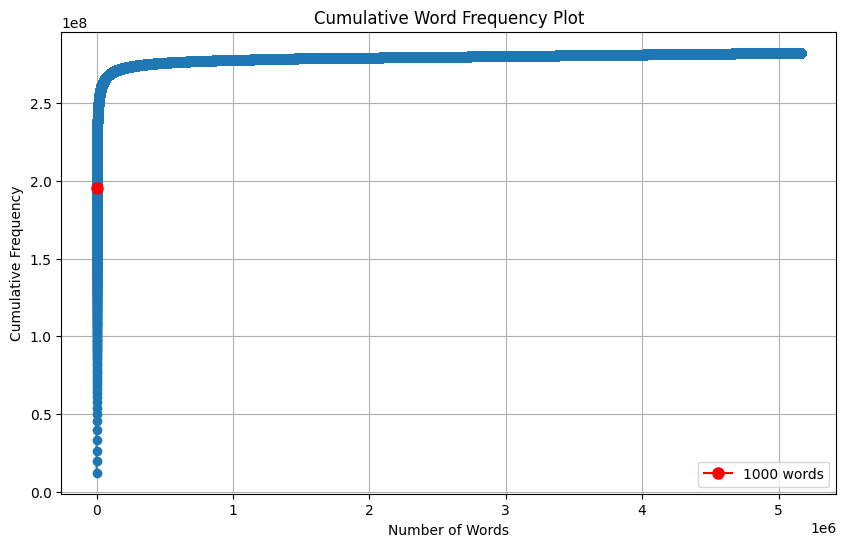

Coordinates of the point corresponding to 12,000 words:
Number of Words: 1000
Cumulative Frequency: 195312311


In [ ]:

#visualize the number of most frequent words
all_words = [word for text in train_texts for word in text.split()]
word_freq = Counter(all_words)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
total_words = len(all_words)
cumulative_freq = 0
cumulative_freq_list = []
num_words_list = []

for word, freq in sorted_word_freq:
    cumulative_freq += freq
    cumulative_freq_list.append(cumulative_freq)
    num_words_list.append(len(cumulative_freq_list))

index_12000 = next(i for i, num_words in enumerate(num_words_list) if num_words >= 1000)
point_12000 = (num_words_list[index_12000], cumulative_freq_list[index_12000])
plt.figure(figsize=(10, 6))
plt.plot(num_words_list, cumulative_freq_list, marker='o', linestyle='-')
plt.plot(point_12000[0], point_12000[1], marker='o', color='red', markersize=8, label='1000 words')
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Word Frequency Plot')
plt.legend()
plt.grid(True)
plt.show()

print("Coordinates of the point corresponding to 12,000 words:")
print("Number of Words:", point_12000[0])
print("Cumulative Frequency:", point_12000[1])